In [7]:
import torch
from transformer_lens import HookedTransformer

model_name = "gpt2"
task = "ioi"

model = HookedTransformer.from_pretrained(model_name, device='mps')
n_layers = model.cfg.n_layers

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


## Score evals

In [10]:
import torch
from transformer_lens import HookedTransformer
import pandas as pd

def load_task_df(task, model_name, n_layers):
    #model_name = "pythia"
    #task = "greater_than_random"
    #n_layers = 6

    sae_circuit = torch.load(f'circuits/findings/{model_name}/{task}/greater_than_dict10_l01_methodig_node0.1_edge0.01_n100_aggnone.pt', map_location=torch.device('cpu'))['nodes']
    comp_circuit = torch.load(f'circuits/findings/{model_name}/{task}/greater_than_dict10_l01_methodexact_node0.1_edge0.01_n100_aggnone.pt', map_location=torch.device('cpu'))['nodes']

    effects_df = {
        'layer': [],
        'component': [],
        'method': [],
        'effect': [],
    }

    for c in ['resid', 'mlp', 'attn']:
        for l in range(n_layers):
            effects_df['layer'].append(l)
            effects_df['component'].append(c)
            effects_df['method'].append('sae')
            effects_df['effect'].append(sae_circuit[f"{c}_{l}"].act.sum().item())

            effects_df['layer'].append(l)
            effects_df['component'].append(c)
            effects_df['method'].append('comp')
            effects_df['effect'].append(comp_circuit[f"{c}_{l}"].act.sum().item())

    effects_df = pd.DataFrame(effects_df)
    return effects_df

## New plots

In [11]:
import torch
from transformer_lens import HookedTransformer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_context("poster")
palette = sns.color_palette("colorblind")



def sae_effects(circuit, aggregate, sae_error, method, threshold, k, verbose):
    if aggregate:
        effects_df["effect"].append(circuit.act.sum().item())
    else:
        if method == "topk":
            eff_act = circuit.act
            eff_resc = circuit.resc
            eff_act = eff_act.topk(k, dim=-1).values
            # resc_mask = eff_resc.topk(k, dim=-1).values

            eff = eff_act.sum(-1) + eff_resc[:, 0] if sae_error else eff_act.sum(-1)
            n = k
        else:
            eff_act = circuit.act
            eff_resc = circuit.resc
            act_mask = eff_act.abs() < threshold
            resc_mask = eff_resc.abs() < threshold

            n = (~act_mask).sum(-1).numpy()

            if verbose:
                print(f"\nSAE\t", end="")
                for i in (~act_mask).sum(-1).tolist():
                    print(f"{i}\t", end="")
                print("RESC\t", end="")
                for i in (~resc_mask).sum(-1).tolist():
                    print(f"{i}\t", end="")

            eff_act[act_mask] = 0
            eff_resc[resc_mask] = 0

            eff = eff_act.sum(-1) + eff_resc[:, 0] if sae_error else eff_act.sum(-1)

    return eff.numpy(), n


def load_task_df(
    task,
    model_name,
    n_layers,
    aggregate=False,
    method="threshold",
    threshold=None,
    k=None,
    sae_error=False,
    verbose=False,
):

    assert method in [
        "threshold",
        "topk",
    ], "Method must be either 'threshold' or 'topk'."
    assert not (
        method == "threshold" and threshold is None
    ), "You must provide a threshold for the threshold method."
    assert not (
        method == "topk" and k is None
    ), "You must provide a k for the topk method."

    try:
        sae_circuit = torch.load(
            f"circuits/findings/{model_name}/{task}/{task}_dict10_l01_methodig_node0.1_edge0.01_n100_aggnone.pt",
            map_location=torch.device("cpu"),
        )
    except:
        print(f"IG not found for {model_name} on {task}. Loading attribution instead.")
        sae_circuit = torch.load(
            f"circuits/findings/{model_name}/{task}/{task}_dict10_l01_methodattrib_node0.1_edge0.01_n100_aggnone.pt",
            map_location=torch.device("cpu"),
        )

    comp_circuit = torch.load(
        f"circuits/findings/{model_name}/{task}/{task}_dict10_l01_methodexact_node0.1_edge0.01_n100_aggnone.pt",
        map_location=torch.device("cpu"),
    )["nodes"]
    sae_circuit = sae_circuit["nodes"]

    effects_df = {"layer": [], "component": [], "method": [], "effect": [], "n": []}

    # other components
    for c in ["resid", "mlp", "attn"]:
        for l in range(n_layers):
            # SAE effects
            effects_df["layer"].append(l)
            effects_df["component"].append(c)
            effects_df["method"].append("sae")

            eff, n = sae_effects(
                sae_circuit[f"{c}_{l}"],
                aggregate,
                sae_error,
                method,
                threshold,
                k,
                verbose,
            )
            effects_df["effect"].append(eff)
            effects_df["n"].append(n)

            # Component effect
            effects_df["layer"].append(l)
            effects_df["component"].append(c)
            effects_df["method"].append("comp")

            if aggregate:
                effects_df["effect"].append(comp_circuit[f"{c}_{l}"].act.sum().item())
                n = 0
            else:
                effects_df["effect"].append(comp_circuit[f"{c}_{l}"].act.numpy())
                n = np.zeros(comp_circuit[f"{c}_{l}"].act.shape[0])
            effects_df["n"].append(n)

    # embed
    # SAE effects
    effects_df["layer"].append(None)
    effects_df["component"].append("embed")
    effects_df["method"].append("sae")

    eff, n = sae_effects(
        sae_circuit[f"embed"], aggregate, sae_error, method, threshold, k, verbose
    )
    effects_df["effect"].append(eff)
    effects_df["n"].append(n)

    # Component effect
    effects_df["layer"].append(None)
    effects_df["component"].append("embed")
    effects_df["method"].append("comp")

    if aggregate:
        effects_df["effect"].append(comp_circuit["embed"].act.sum().item())
        effects_df["n"].append(0)
    else:
        effects_df["effect"].append(comp_circuit["embed"].act.numpy())
        effects_df["n"].append(np.zeros(comp_circuit["embed"].act.shape[0]))

    if not aggregate:
        # print(effects_df['effect'].values.shape)
        effects = np.array([e.flatten() for e in effects_df["effect"]])
        ns = np.array([n.flatten() for n in effects_df["n"]])

        del effects_df["effect"]
        del effects_df["n"]

        df = pd.DataFrame(effects_df)
        effects_df = pd.concat([df, pd.DataFrame(effects)], axis=1).melt(
            id_vars=["layer", "component", "method"],
            var_name="position",
            value_name="effect",
        )

        ns_df = pd.concat([df, pd.DataFrame(ns)], axis=1).melt(
            id_vars=["layer", "component", "method"],
            var_name="position",
            value_name="N",
        )

        return effects_df.join(ns_df["N"])
    
    else:
        return pd.DataFrame(effects_df)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
model_name = "pythia"

tasks = ["ioi", "rc_train", "greater_than", "greater_than_random"]
titles = ["IOI", "Relative Clause", "Greater Than", "Greater Than (Random)"]

layer_map = {"pythia": 6, "gpt2": 12, "gemma": 26}

effects_df = load_task_df(
    "ioi",
    model_name,
    layer_map[model_name],
    aggregate=False,
    method="threshold",
    threshold=0.1,
    k=10,
    sae_error=False,
    verbose=True,
)
effects_df.head()


SAE	0	0	1	0	9	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	0	1	0	0	0	0	0	1	0	0	0	0	
SAE	0	0	0	0	5	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	1	1	0	0	0	0	0	1	0	0	0	0	
SAE	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	1	1	0	0	0	0	0	1	0	0	0	1	
SAE	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	1	1	0	0	0	0	0	1	0	0	0	1	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	
SAE	0	0	2	0	10	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	0	1	0	0	0	0	0	1	0	0	0	0	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	RESC	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	
SAE	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	RESC	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	
SAE	0	0	0	0	0	0	0	

,layer,component,method,position,effect,N
0,0.0,resid,sae,0,0.0,0.0
1,0.0,resid,comp,0,0.0,0.0
2,1.0,resid,sae,0,0.0,0.0
3,1.0,resid,comp,0,0.0,0.0
4,2.0,resid,sae,0,0.0,0.0


In [14]:
import statsmodels.api as sm

def add_ols_fit_by_component(ax, df, x_pos=None, y_pos=None, **kwargs):

    components = ["attn", "mlp", "resid", "embed"]
    colors = {comp: palette[i] for i, comp in enumerate(components)}
    for i, comp in enumerate(components):
        comp_df = df[df["component"] == comp]
        x = comp_df["comp"]
        y = comp_df["sae"]
        # Adding constant to x (intercept term)
        x_with_const = sm.add_constant(x)
        # OLS fit
        model = sm.OLS(y, x_with_const).fit()
        intercept, slope = model.params

        # Define x values slightly beyond the range of the points
        x_min, x_max = x.min(), x.max()
        buffer = 0.15 * (x_max - x_min)  # 5% buffer on either side
        x_vals = np.linspace(x_min - buffer, x_max + buffer, 100)

        # Calculate corresponding y values
        y_vals = intercept + slope * x_vals

        # Plot OLS line
        sns.lineplot(
            x=x_vals,
            y=y_vals,
            linestyle="--",
            linewidth=1,
            color=colors[comp],
            label=f"{comp} fit",
            ax=ax,
            alpha=0.5,
            **kwargs,
        )

        # Annotate equation
        ax.annotate(
            rf"$IE_{{sae}} = {slope:.2f} \cdot IE_{{\text{{{comp}}}}} + {intercept:.2f}$",
            xy=(x_pos[i], y_pos[i]),
            xycoords='axes fraction',
            fontsize=ANNOT_SIZE,
            color=colors[comp],
        )

def add_ols_fit_single_line(ax, df, x_pos=0.05, y_pos=0.95, **kwargs):

    # Combine data across all components
    x = df["comp"]
    y = df["sae"]
    
    # Adding constant to x (intercept term)
    x_with_const = sm.add_constant(x)
    
    # OLS fit on the combined data
    model = sm.OLS(y, x_with_const).fit()
    intercept, slope = model.params

    # Define x values slightly beyond the range of the points
    x_min, x_max = x.min(), x.max()
    buffer = 0.15 * (x_max - x_min)  # 15% buffer on either side
    x_vals = np.linspace(x_min - buffer, x_max + buffer, 100)

    # Calculate corresponding y values for the fitted line
    y_vals = intercept + slope * x_vals

    # Plot the OLS line
    sns.lineplot(
        x=x_vals,
        y=y_vals,
        linestyle="--",
        linewidth=2,
        color="black",  # Use a single color for the combined line
        label="Overall fit",
        ax=ax,
        **kwargs,
    )

    # Annotate the single equation on the plot
    ax.annotate(
        rf"$IE_{{sae}} = {slope:.2f} \cdot IE_{{comp}} + {intercept:.2f}$",
        xy=(x_pos, y_pos),
        xycoords='axes fraction',
        fontsize=12,
        color="black",
    )

def add_x_y_line(df, ax):
    ax.plot(
        [df["comp"].min(), df["comp"].max()],
        [df["comp"].min(), df["comp"].max()],
        linestyle="--",
        linewidth=1,
        color="black",
        alpha=0.5,
    )
    ax.annotate(
        rf"$IE_{{sae}} = IE_{{\text{{comp}}}}$",
        xy=(0.03, 0.97-0.30),
        xycoords='axes fraction',
        fontsize=ANNOT_SIZE,
        color='black',
    )

### No aggregation

In [15]:
model_name = "pythia"
method = "threshold"
threshold = 0.01
k = 100

SCATTER_SIZE = 200
TITLE_SIZE = 24
TITLE_PAD = 20
AX_LABEL_SIZE = 20
TICK_LABEL_SIZE = 18
ANNOT_SIZE = 14
LEGEND_SIZE = 20

/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/3283711727.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/3283711727.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/3283711727.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/3283711727.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


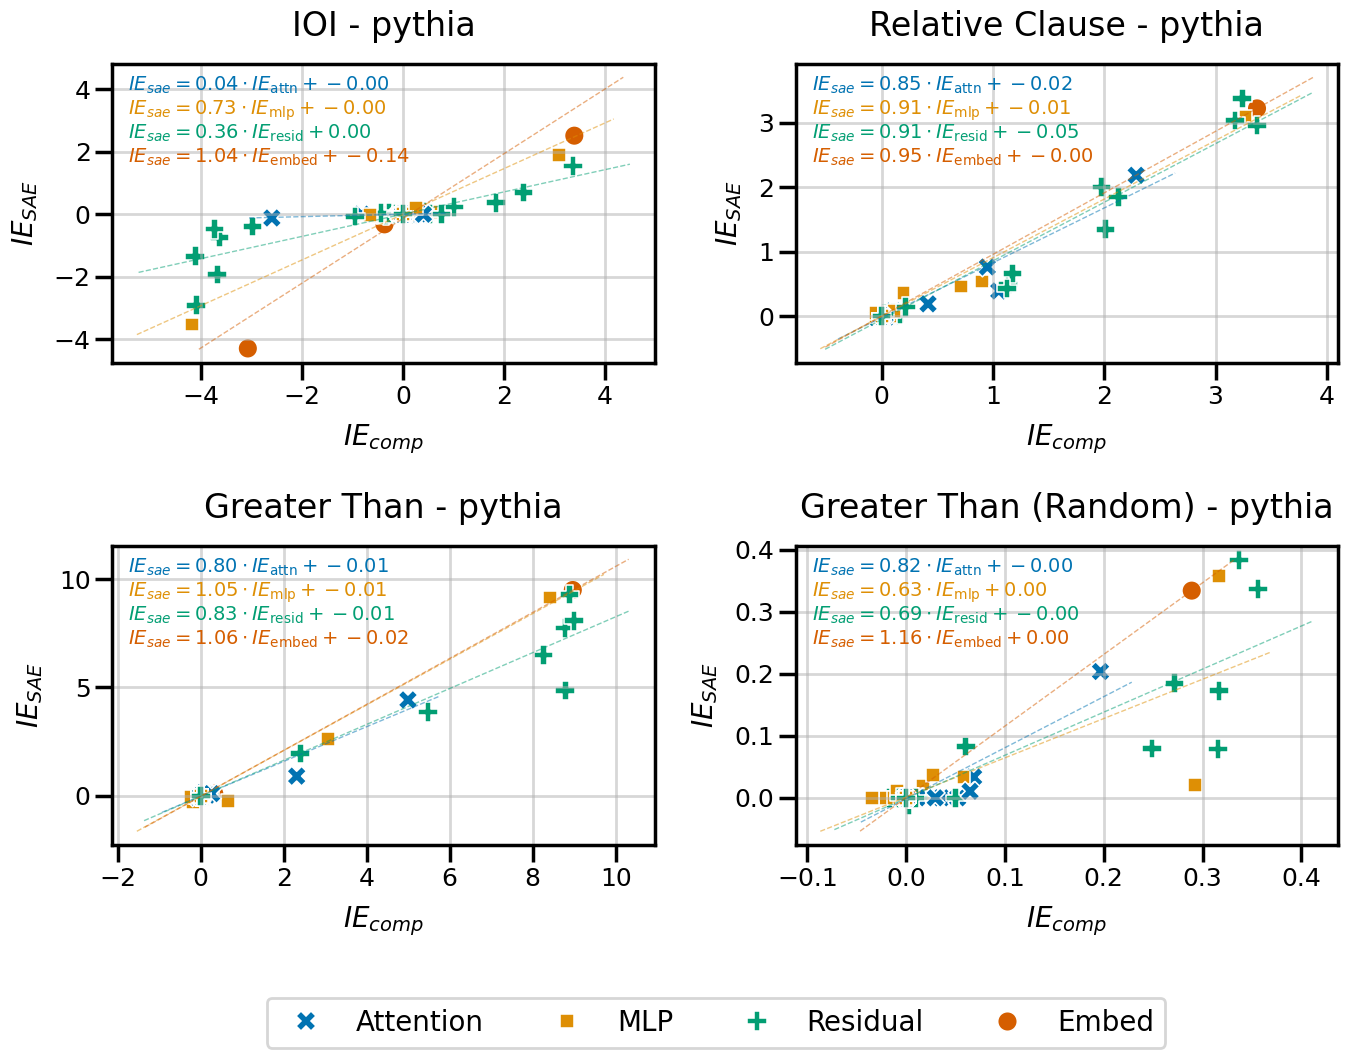

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), dpi=100, layout="tight")

for i, task in enumerate(tasks):
    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
        verbose=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid", "embed"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i // 2, i % 2],
        palette=palette,
        legend=i == 0,
    )

    title = titles[i] + f" - {model_name}"
    ax[i // 2, i % 2].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i // 2, i % 2].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i // 2, i % 2].set_ylabel("$IE_{SAE}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i // 2, i % 2].grid(True, linestyle="-", alpha=0.5)
    ax[i // 2, i % 2].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i // 2, i % 2].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)

    add_ols_fit_by_component(
        ax[i // 2, i % 2],
        plot_df,
        x_pos=[0.03, 0.03, 0.03, 0.03],
        y_pos=[0.97-0.30, 0.97-0.22, 0.97-0.14, 0.97-0.06][::-1],
        legend=False,
    )

## add colorbar
#cbar = plt.cm.ScalarMappable(cmap='viridis')
#cbar.set_array([])
#fig.colorbar(cbar, ax=ax[1, 1], orientation='vertical', pad=0.1)

plt.tight_layout()
# adjust legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Attention", "MLP", "Residual", "Embed"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0, 0].get_legend().remove()
#plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/{model_name}.pdf", bbox_inches="tight", dpi=300)

<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/2507278481.py:32: SyntaxWarning: invalid escape sequence '\e'
  title = titles[i] + f" - {model_name} (with $\epsilon$)"
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/2507278481.py:35: SyntaxWarning: invalid escape sequence '\e'
  ax[i // 2, i % 2].set_ylabel("$IE_{SAE+\epsilon}$", fontsize=AX_LABEL_SIZE, labelpad=10)
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/2507278481.py:19: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/2507278481.py:19: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot

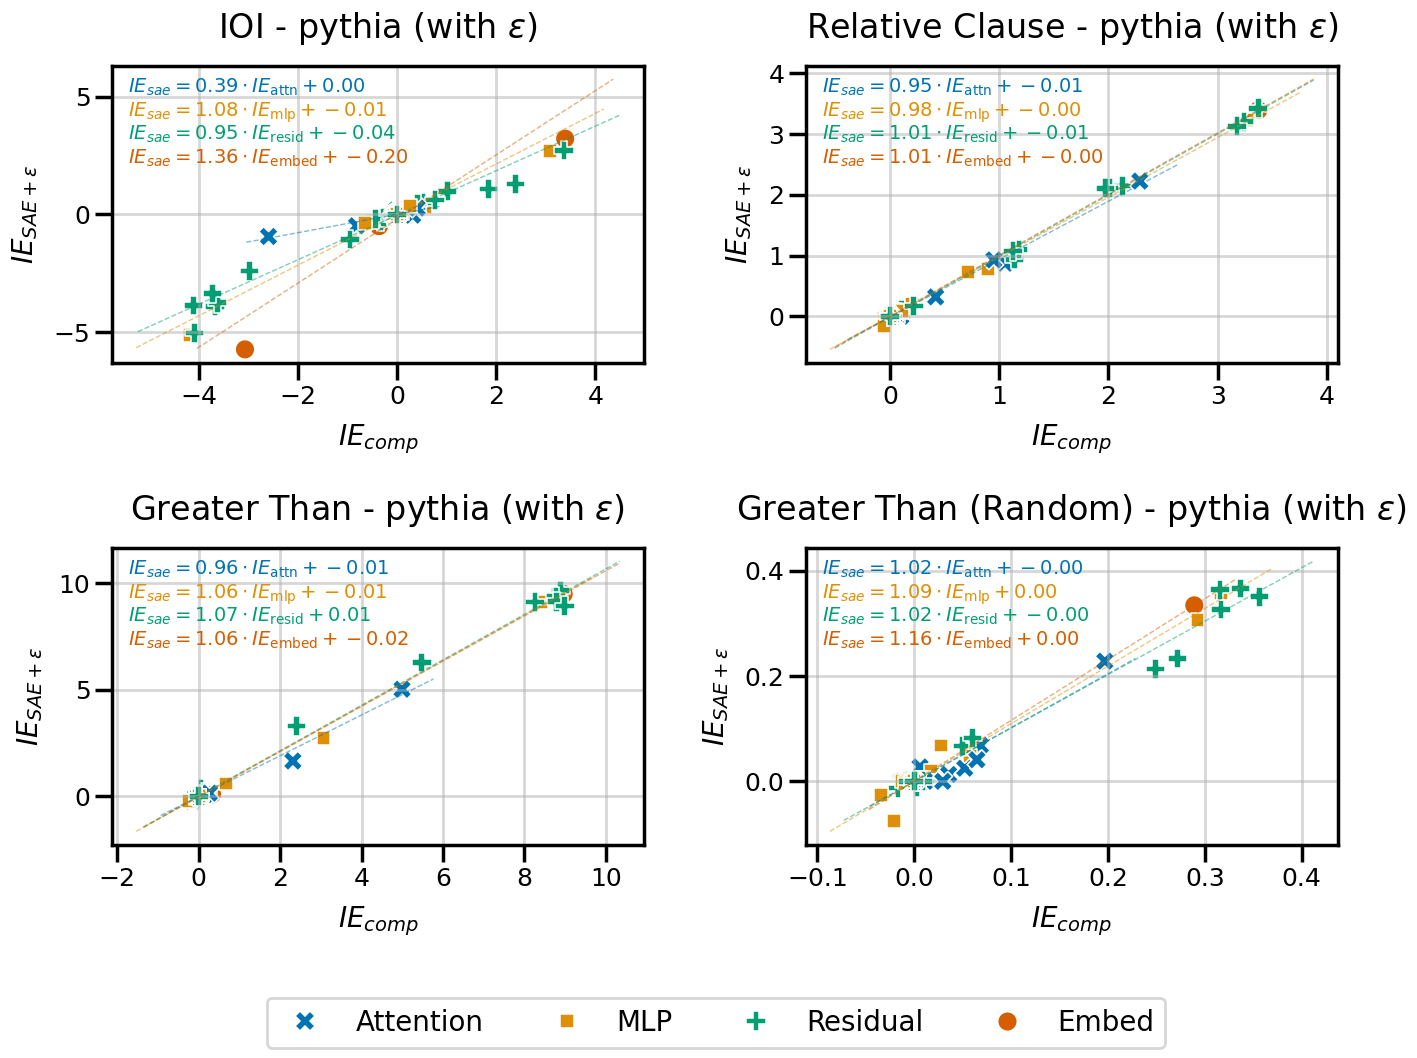

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), dpi=100, layout="tight")

for i, task in enumerate(tasks):
    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=True,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid", "embed"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i // 2, i % 2],
        palette=palette,
        legend=i == 0,
    )

    title = titles[i] + f" - {model_name} (with $\epsilon$)"
    ax[i // 2, i % 2].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i // 2, i % 2].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i // 2, i % 2].set_ylabel("$IE_{SAE+\epsilon}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i // 2, i % 2].grid(True, linestyle="-", alpha=0.5)
    ax[i // 2, i % 2].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i // 2, i % 2].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)

    add_ols_fit_by_component(
        ax[i // 2, i % 2],
        plot_df,
        x_pos=[0.03, 0.03, 0.03, 0.03],
        y_pos=[0.97 - 0.30, 0.97 - 0.22, 0.97 - 0.14, 0.97 - 0.06][::-1],
        legend=False,
    )

plt.tight_layout()
# adjust legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Attention", "MLP", "Residual", "Embed"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0, 0].get_legend().remove()
# plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/{model_name}_sae_err.pdf", bbox_inches="tight", dpi=300)

### Gemma

In [18]:
method = 'threshold'
threshold = 0.01
k = 10

<>:82: SyntaxWarning: invalid escape sequence '\e'
<>:82: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/719142938.py:82: SyntaxWarning: invalid escape sequence '\e'
  title = titles[i] + f" - Gemma (with $\epsilon$)"
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/719142938.py:21: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/719142938.py:69: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/719142938.py:21: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/719142938.py:69: UserWarning: The palette list has more values (10)

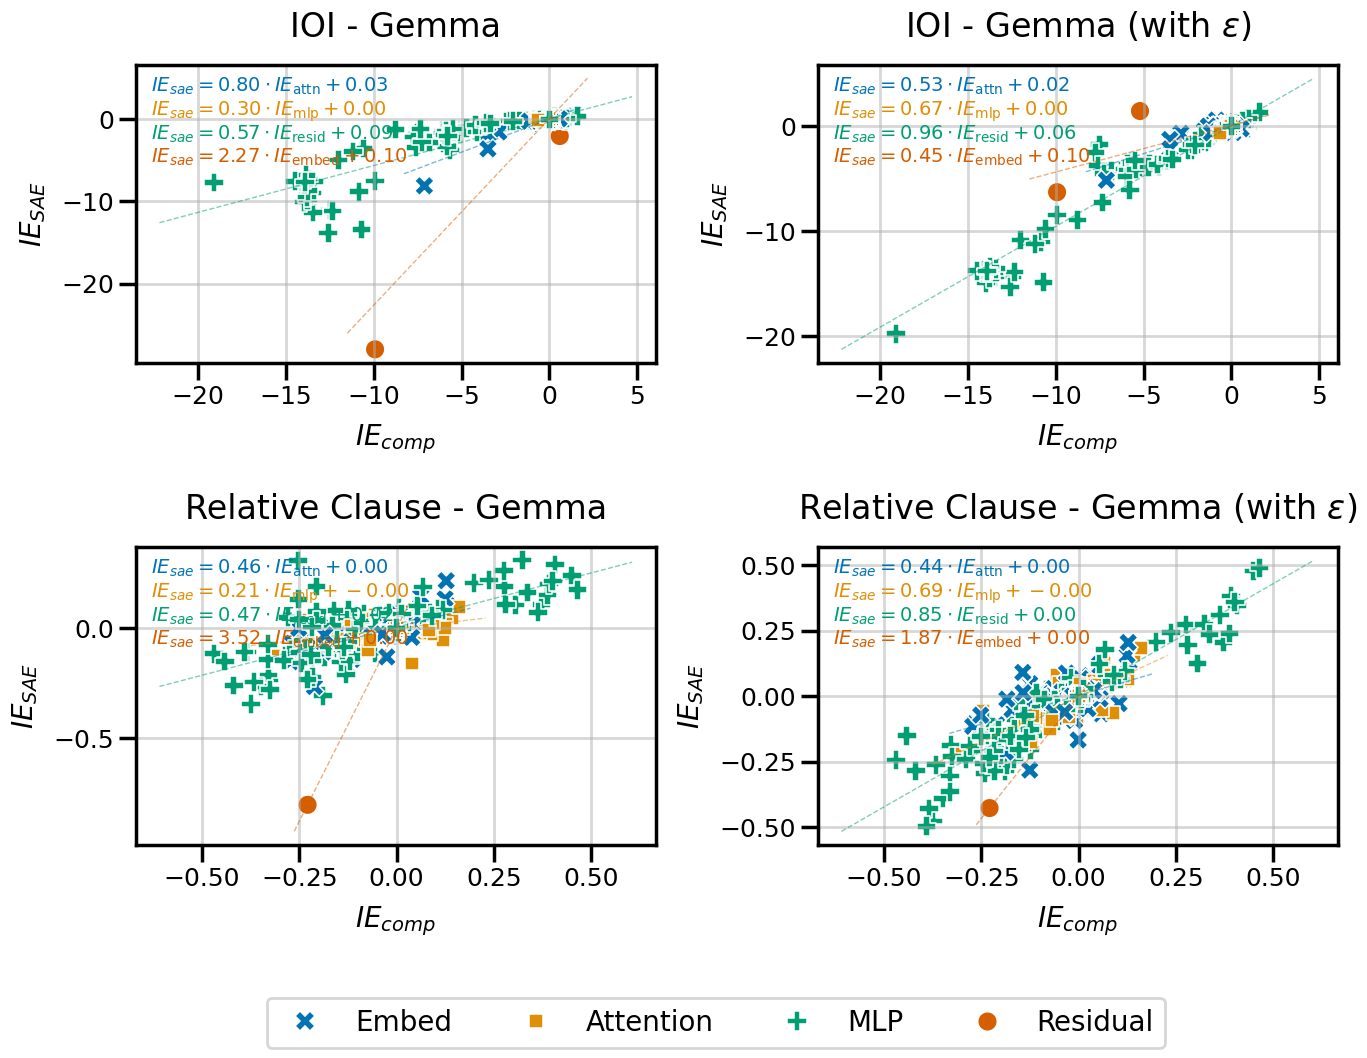

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), dpi=100, layout="tight")

for i, task in enumerate(tasks[:2]):
    # No SAE error
    effects_df = load_task_df(
        task,
        'gemma',
        layer_map['gemma'],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
        verbose=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid", "embed"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i, 0],
        palette=palette,
        legend=i == 0,
    )

    title = titles[i] + f" - Gemma"
    ax[i, 0].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i, 0].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 0].set_ylabel("$IE_{SAE}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 0].grid(True, linestyle="-", alpha=0.5)
    ax[i, 0].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i, 0].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    #ax[i, 0].set_ylim(-0.5, 0.5)


    add_ols_fit_by_component(
        ax[i, 0],
        plot_df,
        x_pos=[0.03, 0.03, 0.03, 0.03],
        y_pos=[0.97-0.30, 0.97-0.22, 0.97-0.14, 0.97-0.06][::-1],
        legend=False,
    )

    # SAE error
    effects_df = load_task_df(
        task,
        'gemma',
        layer_map['gemma'],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=True,
        verbose=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid", "embed"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i, 1],
        palette=palette,
        legend=False,
    )

    title = titles[i] + f" - Gemma (with $\epsilon$)"
    ax[i, 1].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i, 1].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 1].set_ylabel("$IE_{SAE}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 1].grid(True, linestyle="-", alpha=0.5)
    ax[i, 1].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i, 1].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    #ax[i, 1].set_ylim(-0.5, 0.5)


    add_ols_fit_by_component(
        ax[i, 1],
        plot_df,
        x_pos=[0.03, 0.03, 0.03, 0.03],
        y_pos=[0.97-0.30, 0.97-0.22, 0.97-0.14, 0.97-0.06][::-1],
        legend=False,
    )

#ax[0, 0].set_xlim(-2.5, 2.5)
#ax[0, 1].set_xlim(-2.5, 2.5)
plt.tight_layout()
# adjust legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Embed", "Attention", "MLP", "Residual"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0, 0].get_legend().remove()
#plt.suptitle(f"{'gemma'.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/gemma.pdf", bbox_inches="tight", dpi=300)

### W/o SAE error

In [76]:
task = "ioi"

<>:63: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/3208185189.py:63: SyntaxWarning: invalid escape sequence '\e'
  title = titles[0] + f" - {model_name} (with $\epsilon$)"
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/3208185189.py:81: SyntaxWarning: invalid escape sequence '\e'
  ax[i, 1].set_ylabel("$IE_{SAE + \epsilon}$", fontsize=AX_LABEL_SIZE, labelpad=10)
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/3208185189.py:21: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/3208185189.py:66: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/var/fold

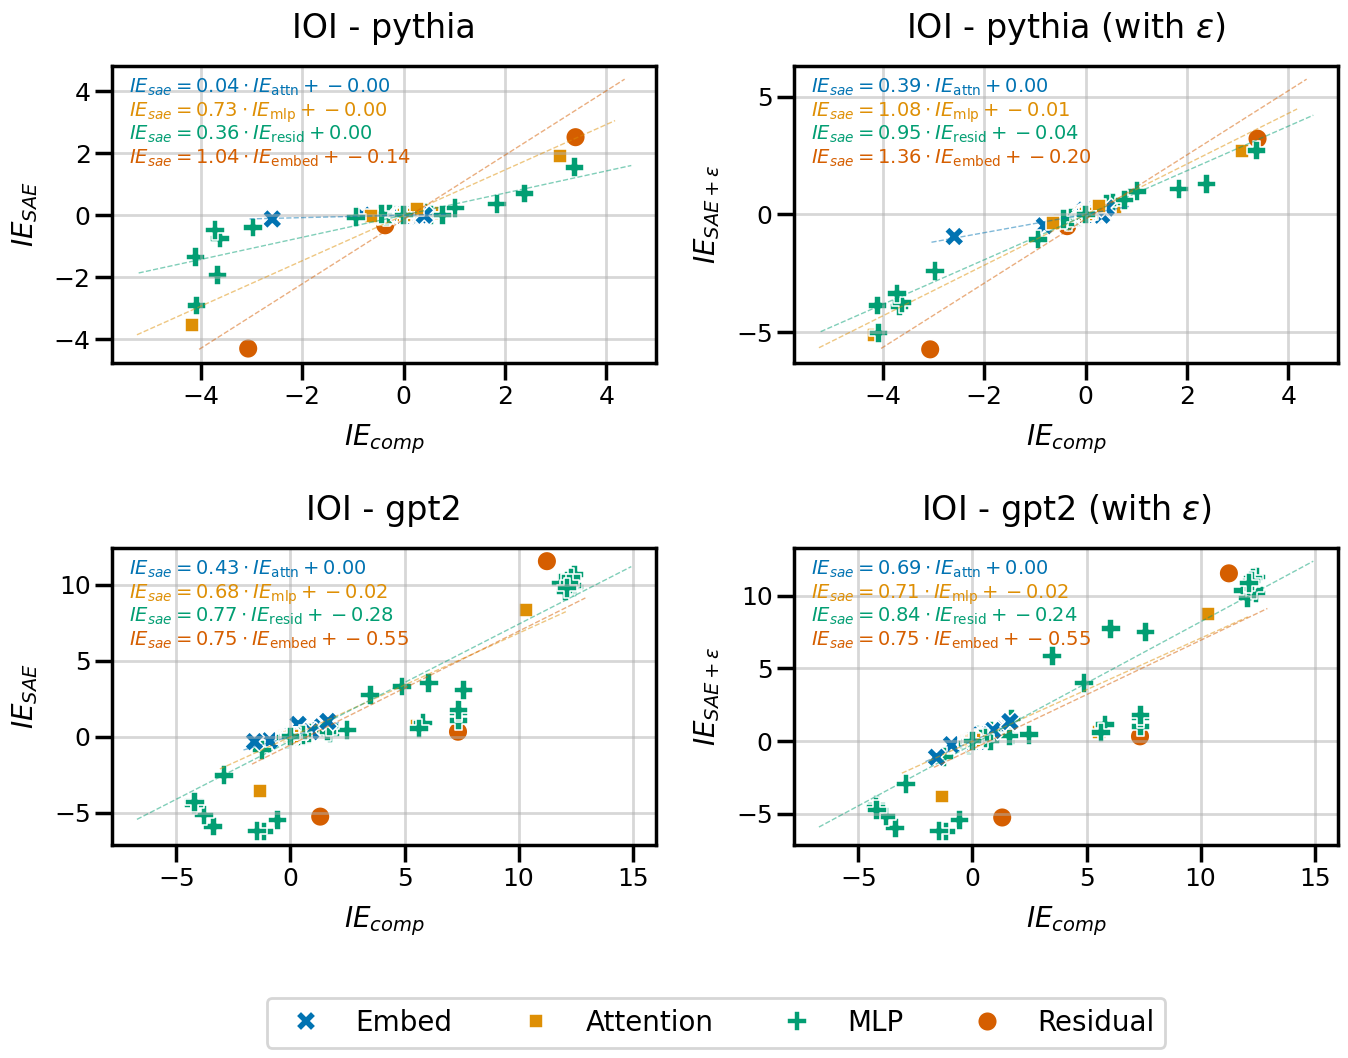

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), dpi=100, layout="tight")

for i, model_name in enumerate(["pythia", "gpt2"]):
    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    title = titles[0] + f" - {model_name}"

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid", "embed"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i, 0],
        palette=palette,
        legend=i == 0,
    )

    ax[i, 0].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i, 0].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 0].set_ylabel("$IE_{SAE}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 0].grid(True, linestyle="-", alpha=0.5)
    ax[i, 0].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i, 0].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)

    add_ols_fit_by_component(
        ax[i, 0],
        plot_df,
        x_pos=[0.03, 0.03, 0.03, 0.03],
        y_pos=[0.97 - 0.30, 0.97 - 0.22, 0.97 - 0.14, 0.97 - 0.06][::-1],
        legend=False,
    )

    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=True,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    title = titles[0] + f" - {model_name} (with $\epsilon$)"

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid", "embed"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i, 1],
        palette=palette,
        legend=False,
    )

    ax[i, 1].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i, 1].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 1].set_ylabel("$IE_{SAE + \epsilon}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 1].grid(True, linestyle="-", alpha=0.5)
    ax[i, 1].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i, 1].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)

    add_ols_fit_by_component(
        ax[i, 1],
        plot_df,
        x_pos=[0.03, 0.03, 0.03, 0.03],
        y_pos=[0.97 - 0.30, 0.97 - 0.22, 0.97 - 0.14, 0.97 - 0.06][::-1],
        legend=False,
    )


plt.tight_layout()
# adjust legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Embed", "Attention", "MLP", "Residual"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0, 0].get_legend().remove()
# plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/ioi.pdf", bbox_inches="tight", dpi=300)

## Number of components

In [223]:
model_name = "gpt2"
threshold=0.01

/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2570816922.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2570816922.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


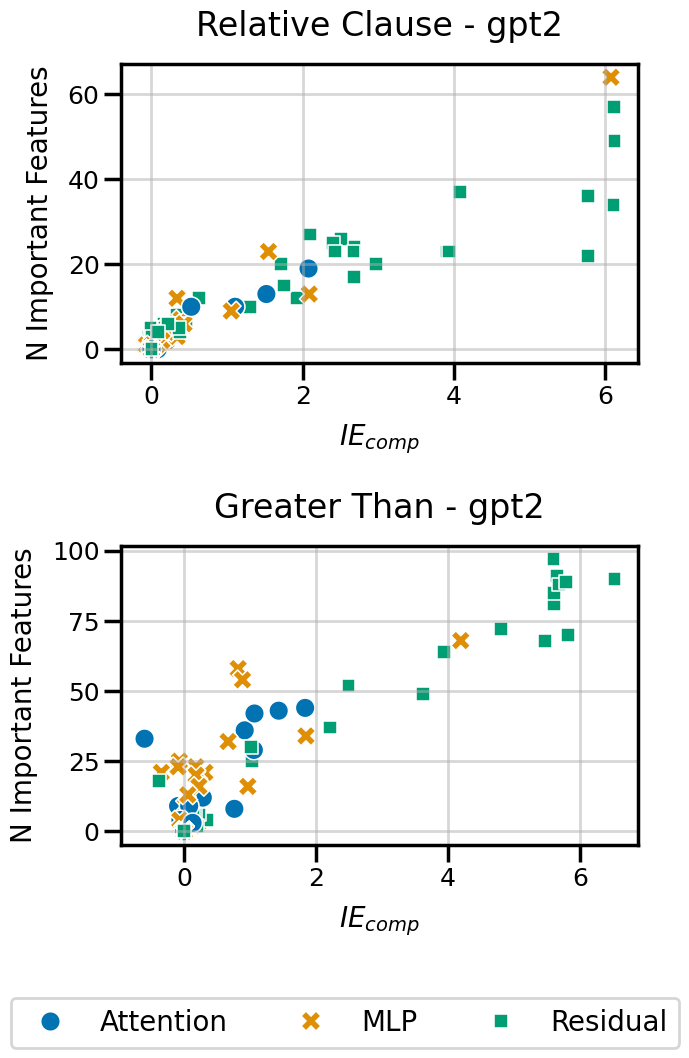

In [224]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10), dpi=100, layout="tight")

for i, task in enumerate(tasks[1:3]):
    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    plot_df_n = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="N"
    ).reset_index()

    plot_df["sae"] = plot_df_n["sae"]
    plot_df = plot_df[plot_df["component"] != "embed"]

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i],
        palette=palette,
        legend=i == 0,
    )

    title = titles[i+1] + f" - {model_name}"
    ax[i].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i].set_ylabel("N Important Features", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i].grid(True, linestyle="-", alpha=0.5)
    ax[i].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    #ax[i].set_ylim(-1, 30)

    #add_ols_fit_by_component(
    #    ax[i],
    #    plot_df,
    #    x_pos=[0.03, 0.03, 0.03, 0.03],
    #    y_pos=[0.97 - 0.30, 0.97 - 0.22, 0.97 - 0.14, 0.97 - 0.06][::-1],
    #    legend=False,
    #)

plt.tight_layout()
# adjust legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Attention", "MLP", "Residual"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0].get_legend().remove()

# plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/{model_name}_n_paper.pdf", bbox_inches="tight", dpi=300)

In [213]:
model_name = "pythia"
threshold=0.01

/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/13237742.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/13237742.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/13237742.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/13237742.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


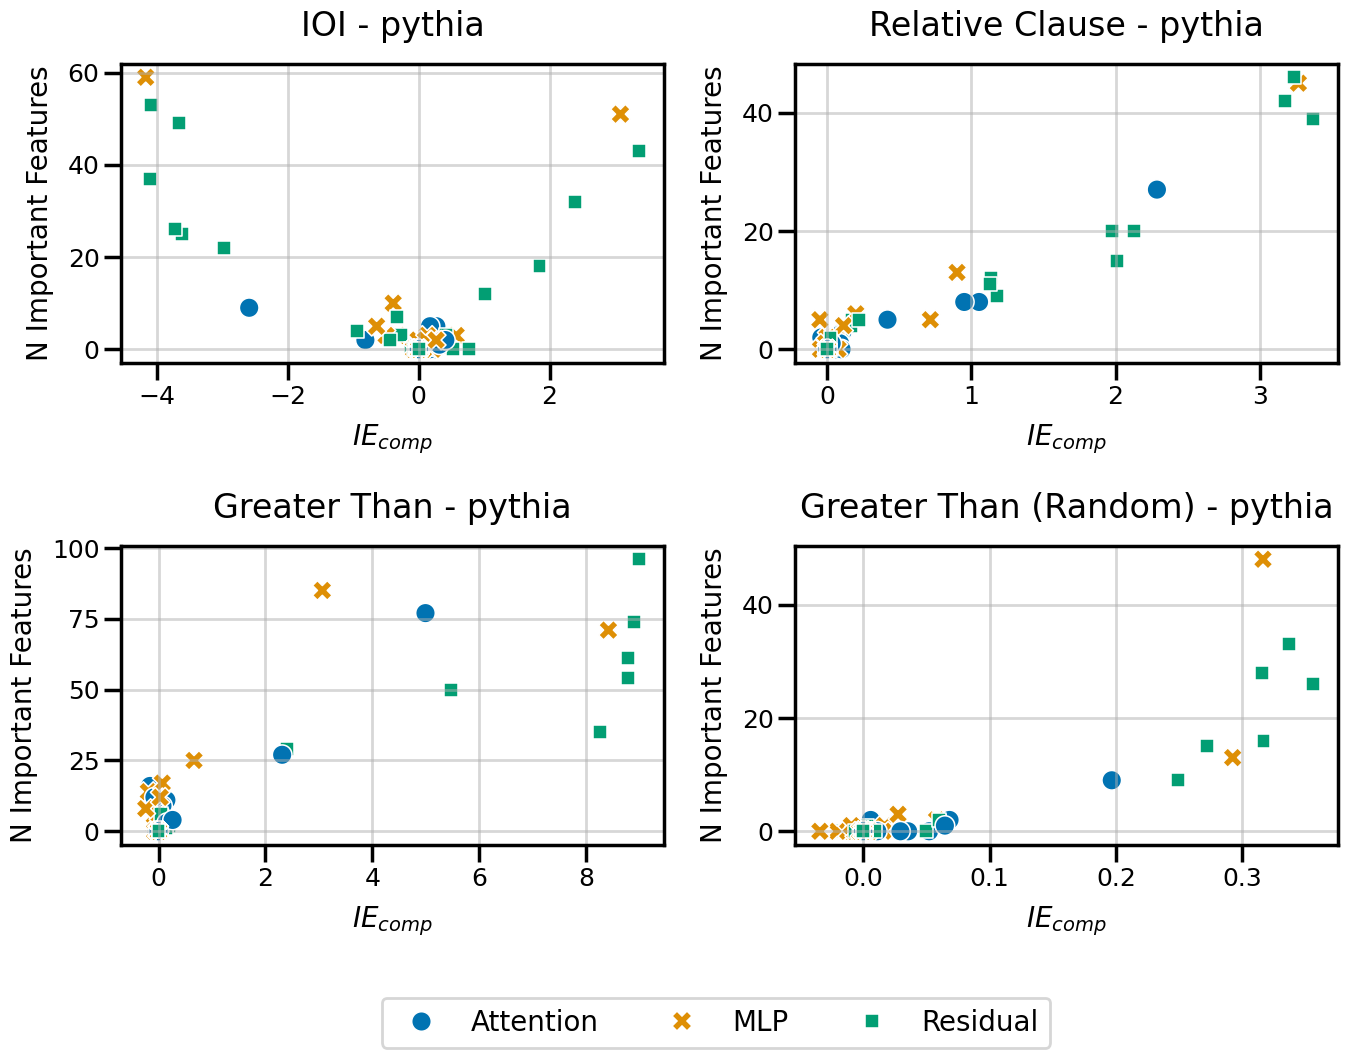

In [214]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), dpi=100, layout="tight")

for i, task in enumerate(tasks):
    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    plot_df_n = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="N"
    ).reset_index()

    plot_df["sae"] = plot_df_n["sae"]
    plot_df = plot_df[plot_df["component"] != "embed"]

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i//2, i%2],
        palette=palette,
        legend=i == 0,
    )

    title = titles[i] + f" - {model_name}"
    ax[i//2, i%2].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i//2, i%2].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i//2, i%2].set_ylabel("N Important Features", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i//2, i%2].grid(True, linestyle="-", alpha=0.5)
    ax[i//2, i%2].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i//2, i%2].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    #ax[i//2, i%2].set_ylim(-1, 30)
    #ax[i//2, i%2].set_xlim(-20, 5)

    #add_ols_fit_by_component(
    #    ax[i//2, i%2],
    #    plot_df,
    #    x_pos=[0.03, 0.03, 0.03, 0.03],
    #    y_pos=[0.97 - 0.30, 0.97 - 0.22, 0.97 - 0.14, 0.97 - 0.06][::-1],
    #    legend=False,
    #)

plt.tight_layout()
# adjust legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Attention", "MLP", "Residual"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0, 0].get_legend().remove()

# plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/{model_name}_n.pdf", bbox_inches="tight", dpi=300)

In [24]:
model_name = "gemma"
threshold=0.01

/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/3413899674.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/3413899674.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


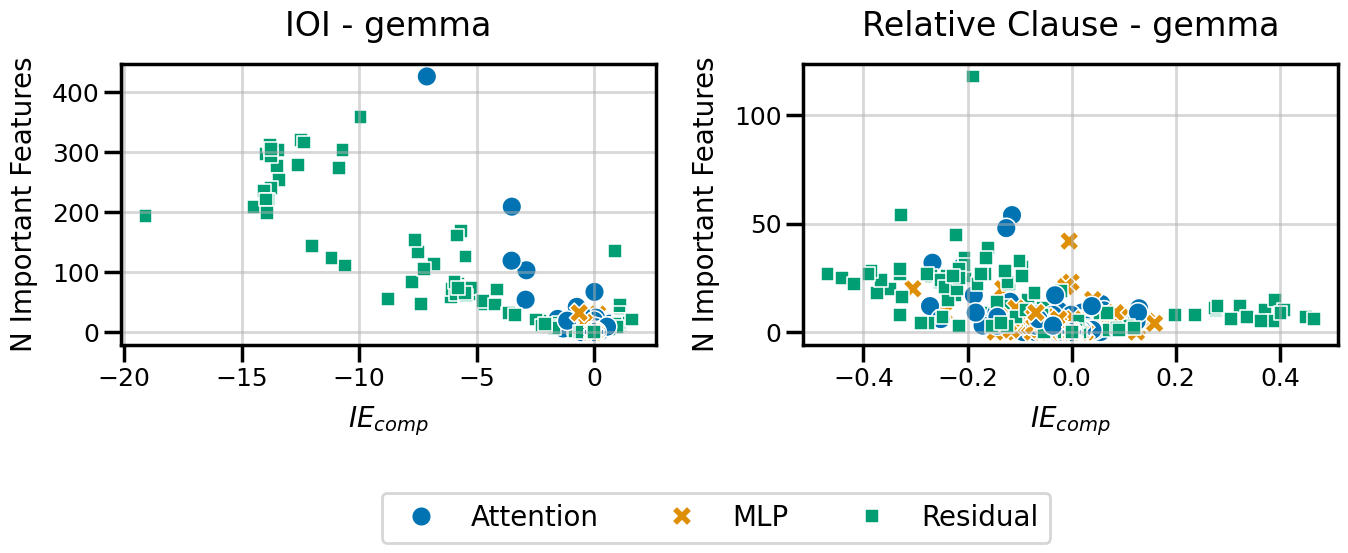

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=100, layout="tight")

for i, task in enumerate(tasks[:2]):
    effects_df = load_task_df(
        task,
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    plot_df_n = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="N"
    ).reset_index()

    plot_df["sae"] = plot_df_n["sae"]
    plot_df = plot_df[plot_df["component"] != "embed"]

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i],
        palette=palette,
        legend=i == 0,
    )

    title = titles[i] + f" - {model_name}"
    ax[i].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i].set_ylabel("N Important Features", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i].grid(True, linestyle="-", alpha=0.5)
    ax[i].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    #ax[i].set_ylim(-10, 450)
    #ax[i].set_xlim(-20, 5)

    #add_ols_fit_by_component(
    #    ax[i],
    #    plot_df,
    #    x_pos=[0.03, 0.03, 0.03, 0.03],
    #    y_pos=[0.97 - 0.30, 0.97 - 0.22, 0.97 - 0.14, 0.97 - 0.06][::-1],
    #    legend=False,
    #)

plt.tight_layout()
# adjust legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Attention", "MLP", "Residual"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0].get_legend().remove()

# plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/{model_name}_n.pdf", bbox_inches="tight", dpi=300)

In [142]:
effects_df[(effects_df['N'] > 30) & (effects_df['effect'].abs() < 0.1)]

,layer,component,method,position,effect,N
212,1.0,mlp,sae,1,-0.037028,42.0
274,6.0,attn,sae,1,-0.068970,32.0
656,12.0,resid,sae,4,0.080050,39.0
816,13.0,resid,sae,5,0.012228,34.0
818,14.0,resid,sae,5,0.034209,34.0


<>:88: SyntaxWarning: invalid escape sequence '\e'
<>:88: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2313282551.py:88: SyntaxWarning: invalid escape sequence '\e'
  ax[i, 1].set_ylabel("$IE_{SAE + \epsilon}$", fontsize=AX_LABEL_SIZE, labelpad=10)
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2313282551.py:28: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2313282551.py:73: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2313282551.py:28: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_5554/2313282551.py:73: UserWarning: The p

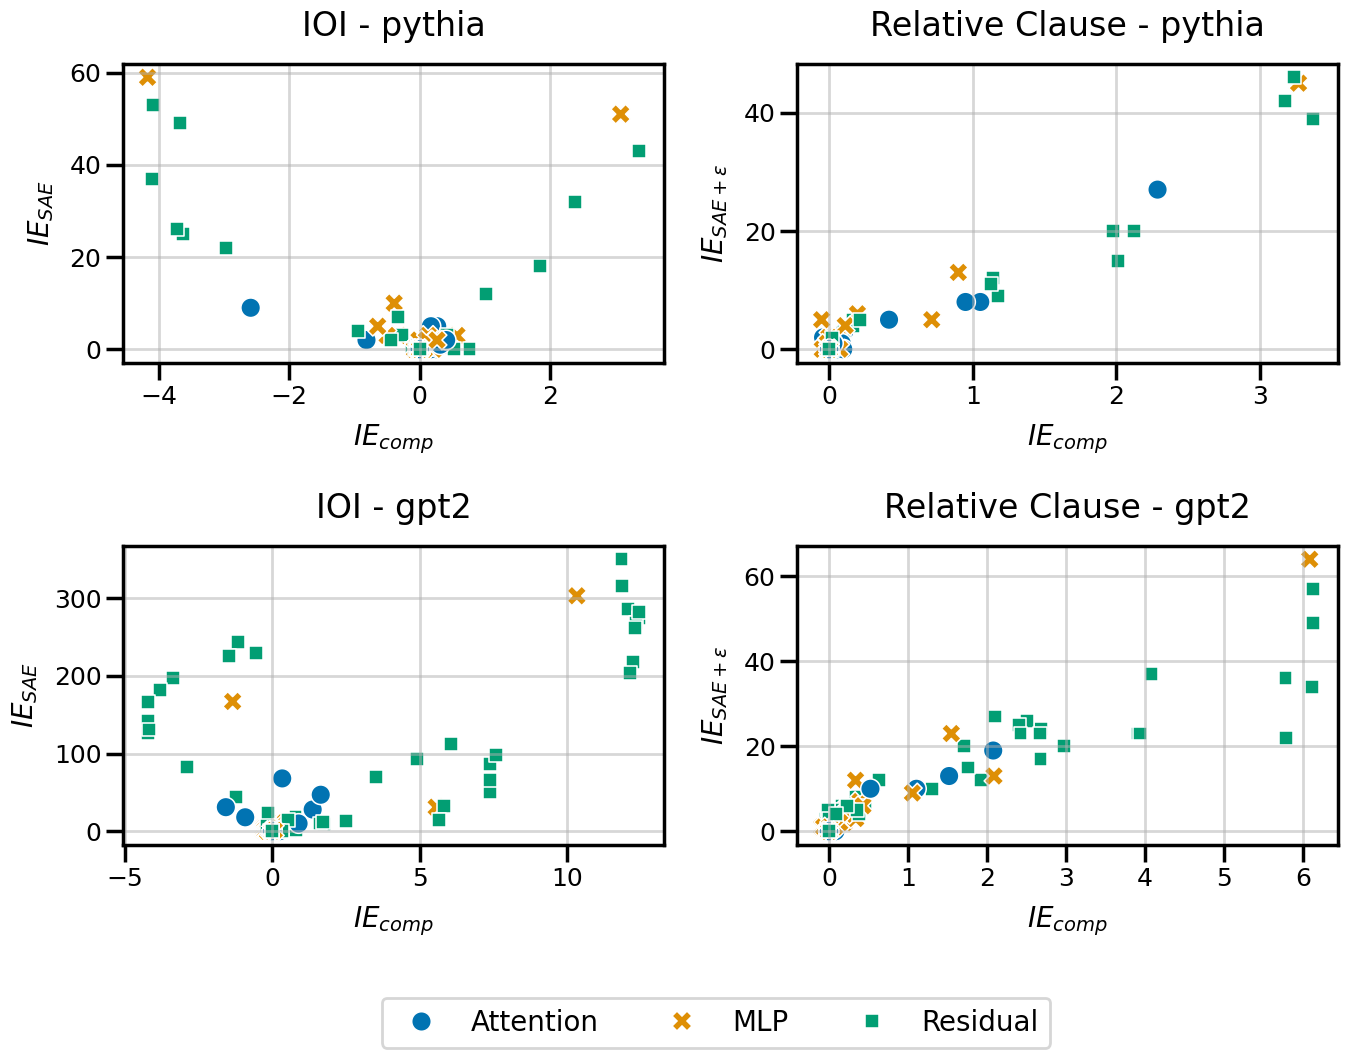

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), dpi=100, layout="tight")

for i, model_name in enumerate(["pythia", "gpt2"]):
    effects_df = load_task_df(
        "ioi",
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=False,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    plot_df_n = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="N"
    ).reset_index()

    plot_df["sae"] = plot_df_n["sae"]
    plot_df = plot_df[plot_df["component"] != "embed"]

    title = titles[0] + f" - {model_name}"

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i, 0],
        palette=palette,
        legend=i == 0,
    )

    ax[i, 0].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i, 0].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 0].set_ylabel("$IE_{SAE}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 0].grid(True, linestyle="-", alpha=0.5)
    ax[i, 0].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i, 0].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)


    effects_df = load_task_df(
        "rc_train",
        model_name,
        layer_map[model_name],
        aggregate=False,
        method=method,
        threshold=threshold,
        k=k,
        sae_error=True,
    )
    plot_df = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="effect"
    ).reset_index()

    plot_df_n = effects_df.pivot(
        index=["layer", "component", "position"], columns="method", values="N"
    ).reset_index()

    plot_df["sae"] = plot_df_n["sae"]
    plot_df = plot_df[plot_df["component"] != "embed"]

    title = titles[1] + f" - {model_name}"

    # Plot all components in a single plot
    sns.scatterplot(
        data=plot_df,
        x="comp",
        y="sae",
        hue="component",
        hue_order=["attn", "mlp", "resid"],
        style="component",
        s=SCATTER_SIZE,
        ax=ax[i, 1],
        palette=palette,
        legend=False,
    )

    ax[i, 1].set_title(title, fontsize=TITLE_SIZE, pad=TITLE_PAD)
    ax[i, 1].set_xlabel("$IE_{comp}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 1].set_ylabel("$IE_{SAE + \epsilon}$", fontsize=AX_LABEL_SIZE, labelpad=10)
    ax[i, 1].grid(True, linestyle="-", alpha=0.5)
    ax[i, 1].xaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    ax[i, 1].yaxis.set_tick_params(labelsize=TICK_LABEL_SIZE)
    #ax[i, 1].vlines(0, 0, plot_df['sae'].max(), linestyle="-", alpha=1, linewidth=1, color='black', zorder=-1)


plt.tight_layout()
# adjust legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles[:4],
    labels=["Attention", "MLP", "Residual"],
    loc="upper center",
    ncol=4,
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(0.53, -0.01),
)
# remove legend from the forst plot
ax[0, 0].get_legend().remove()
# plt.suptitle(f"{model_name.replace('_', ' ').upper()} - SAE vs Component Effect", fontsize=24, y=1.05)
plt.savefig(f"plots/ioi_rc_n.pdf", bbox_inches="tight", dpi=300)

## Efficiency

pythia-70m-deduped rc_train percentage 0.5 thresh 0.01 sum_total 415 sum_our_method 344 frac 0.8289156626506025
pythia-70m-deduped rc_train percentage 0.55 thresh 0.01 sum_total 415 sum_our_method 357 frac 0.8602409638554217
pythia-70m-deduped rc_train percentage 0.6 thresh 0.01 sum_total 415 sum_our_method 366 frac 0.8819277108433735
pythia-70m-deduped ioi percentage 0.5 thresh 0.01 sum_total 643 sum_our_method 602 frac 0.9362363919129082
pythia-70m-deduped ioi percentage 0.55 thresh 0.01 sum_total 643 sum_our_method 605 frac 0.9409020217729394
pythia-70m-deduped ioi percentage 0.6 thresh 0.01 sum_total 643 sum_our_method 613 frac 0.9533437013996889
pythia-70m-deduped greater_than percentage 0.5 thresh 0.01 sum_total 900 sum_our_method 635 frac 0.7055555555555556
pythia-70m-deduped greater_than percentage 0.55 thresh 0.01 sum_total 900 sum_our_method 720 frac 0.8
pythia-70m-deduped greater_than percentage 0.6 thresh 0.01 sum_total 900 sum_our_method 750 frac 0.8333333333333334
gpt2 rc

/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_40611/475577713.py:111: UserWarning: Mismatched number of handles and labels: len(handles) = 7 len(labels) = 3
  plt.legend(


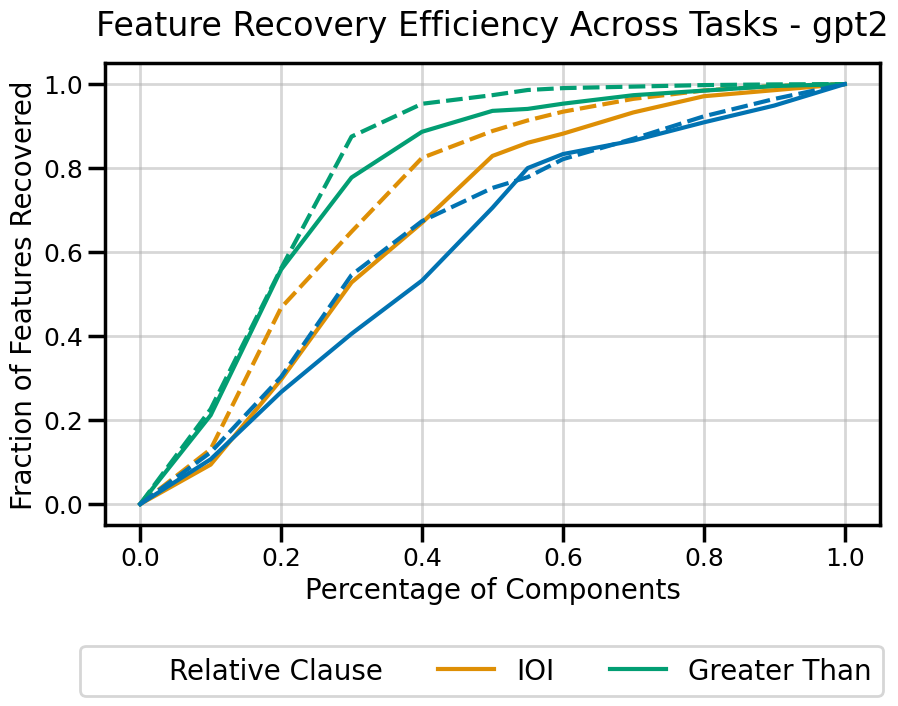

In [54]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch as t
from typing import Dict

percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1]
models = ["pythia-70m-deduped", "gpt2"]
tasks = ["rc_train", "ioi", "greater_than"]  # Add more tasks as needed

DATASET_SHORT_NAME: Dict[str, str] = {
    "rc_train": "rc",
    "greater_than": "gtthan",
    "greater_than_random_tokens": "dummy",
    "ioi": "ioi",
}

MODEL_SHORT_NAME: Dict[str, str] = {
    "pythia-70m-deduped": "pythia",
    "gpt2": "gpt2",
    "gemma-2-2b": "gemma",
}

THRESHOLD_SAE = 0.01

data = []
for model in models:
    for task in tasks:
        # sae_effects_attrib_path = f"/Users/../Desktop/sae-feature-circuits/circuits/attribandig_{MODEL_SHORT_NAME[model]}_{DATASET_SHORT_NAME[task]}/{task}_dict10_l01_methodattrib_node0.1_edge0.01_n100_aggnone.pt"
        # sae_effects_ig_path = f"/Users/../Desktop/sae-feature-circuits/circuits/attribandig_{MODEL_SHORT_NAME[model]}_{DATASET_SHORT_NAME[task]}/{task}_dict10_l01_methodig_node0.1_edge0.01_n100_aggnone.pt"
        sae_effects_attrib_path = f"circuits/findings/{MODEL_SHORT_NAME[model]}/{task}/{task}_dict10_l01_methodig_node0.1_edge0.01_n100_aggnone.pt"
        sae_effects_ig_path = f"circuits/findings/{MODEL_SHORT_NAME[model]}/{task}/{task}_dict10_l01_methodig_node0.1_edge0.01_n100_aggnone.pt"
        with open(sae_effects_attrib_path, "rb") as infile:
            attrib_nodes = t.load(infile, map_location=t.device("cpu"))["nodes"]

        with open(sae_effects_ig_path, "rb") as infile:
            nodes = t.load(infile, map_location=t.device("cpu"))["nodes"]

        effects = {
            k: t.sort(t.abs(v.act.sum(dim=-1) + v.resc.squeeze()), descending=True)[0]
            for k, v in attrib_nodes.items()
        }
        top_component_names = sorted(
            effects.keys(), key=lambda k: effects[k][0], reverse=True
        )

        for percentage in percentages:
            nodes_n = int(len(nodes.keys()) * percentage)
            components_to_consider = top_component_names[:nodes_n]

            sum_total = 0
            sum_our_method = 0
            for k in nodes.keys():
                important_saes_for_this_node = (
                    (nodes[k].act.abs() > THRESHOLD_SAE).sum().item()
                )
                sum_total += important_saes_for_this_node
                if k in components_to_consider:
                    sum_our_method += important_saes_for_this_node

            data.append(
                {
                    "Task": task,
                    "Percentage": percentage,
                    "Model": model,
                    "Features Recovered": sum_our_method / sum_total,
                }
            )
            if percentage == 0.5 or percentage == 0.6 or percentage == 0.55:
                print(
                    model,
                    task,
                    "percentage",
                    percentage,
                    "thresh",
                    THRESHOLD_SAE,
                    "sum_total",
                    sum_total,
                    "sum_our_method",
                    sum_our_method,
                    "frac",
                    sum_our_method / sum_total,
                )

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.set_context("poster")
colorblind_palette = sns.color_palette("colorblind")

sns.lineplot(
    data=df,
    x="Percentage",
    y="Features Recovered",
    hue="Task",
    style="Model",
    palette=[colorblind_palette[1], colorblind_palette[2], colorblind_palette[0]],
)

plt.xlabel("Percentage of Components", fontsize=AX_LABEL_SIZE)
plt.ylabel("Fraction of Features Recovered", fontsize=AX_LABEL_SIZE)
plt.title(
    f"Feature Recovery Efficiency Across Tasks - {MODEL_SHORT_NAME[model]}",
    fontsize=TITLE_SIZE,
    pad=TITLE_PAD,
)
plt.grid(True, linestyle="-", alpha=0.5)
plt.xticks(fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=["Relative Clause", "IOI", "Greater Than"],
    fontsize=LEGEND_SIZE,
    bbox_to_anchor=(-0.05, -0.4),
    loc="lower left",
    ncols=3,
)
plt.show()

In [ ]:
# TODO: modify to include all models.

### Faithfulness

In [ ]:
import seaborn as sns
import pandas as pd

f_scores = pd.read_csv('faithfulness/gpt2_faithfulness.csv')
tasks = ['rc_train', 'greater_than_examples', 'ioi_examples']  # Add more tasks as needed

In [ ]:
fig = plt.figure(figsize=(10, 6), dpi=100)

sns.lineplot(
    f_scores[(f_scores['task'] == 'rc_train') & (f_scores['sae_threshold'] == 30)],
    x='components', y='score', palette=palette[1:2]
)

sns.scatterplot(
    f_scores[(f_scores['task'] == 'rc_train') & (f_scores['sae_threshold'] == 30)],
    x='components', y='score', palette=palette[1:2], s=300
)

plt.grid(True)
plt.xlabel('N Components', labelpad=10)
plt.ylabel('Faithfulness Score', labelpad=10)
plt.title('Relative Clause - GPT2', pad=20)
plt.savefig('plots/faithfulness.pdf', bbox_inches='tight')